In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from itertools import product
import warnings
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
warnings.filterwarnings("ignore", category=UserWarning)
%matplotlib inline

In [4]:
airlines_passengers = pd.read_csv("international-airline-passengers.csv") 
print(airlines_passengers.head())
print(airlines_passengers.info())

     Month  Count
0  1949-01    112
1  1949-02    118
2  1949-03    132
3  1949-04    129
4  1949-05    121
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Month   144 non-null    object
 1   Count   144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB
None


In [5]:
airlines_passengers['Month'] = pd.to_datetime(airlines_passengers['Month'])
airlines_passengers.set_index('Month', inplace=True)

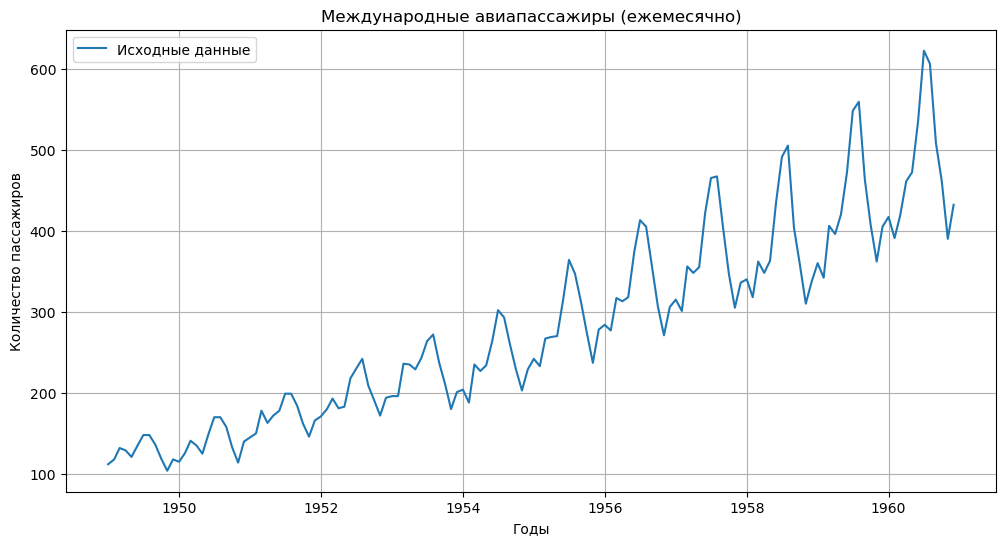

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(airlines_passengers['Count'], label='Исходные данные')
plt.title('Международные авиапассажиры (ежемесячно)')
plt.xlabel('Годы')
plt.ylabel('Количество пассажиров')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
def adf_test(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] <= 0.05:
        print("Ряд стационарен (H0 отвергается)")
    else:
        print("Ряд нестационарен (H0 не отвергается)")

adf_test(airlines_passengers['Count'])

ADF Statistic: 0.8153688792060435
p-value: 0.9918802434376409
Ряд нестационарен (H0 не отвергается)


In [8]:
airlines_diff = airlines_passengers['Count'].diff().dropna()
adf_test(airlines_diff)

ADF Statistic: -2.829266824169982
p-value: 0.054213290283827854
Ряд нестационарен (H0 не отвергается)


In [9]:
airlines_diff2 = airlines_passengers['Count'].diff().diff().dropna()
adf_test(airlines_diff2)

ADF Statistic: -16.38423154246855
p-value: 2.732891850013928e-29
Ряд стационарен (H0 отвергается)


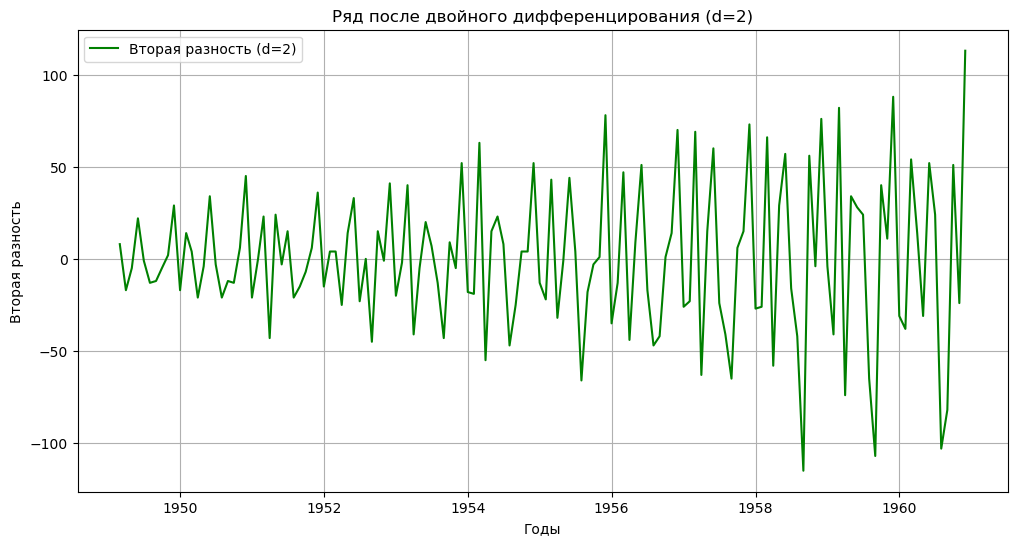

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(airlines_diff2, label='Вторая разность (d=2)', color='green')
plt.title('Ряд после двойного дифференцирования (d=2)')
plt.xlabel('Годы')
plt.ylabel('Вторая разность')
plt.legend()
plt.grid(True)
plt.show()

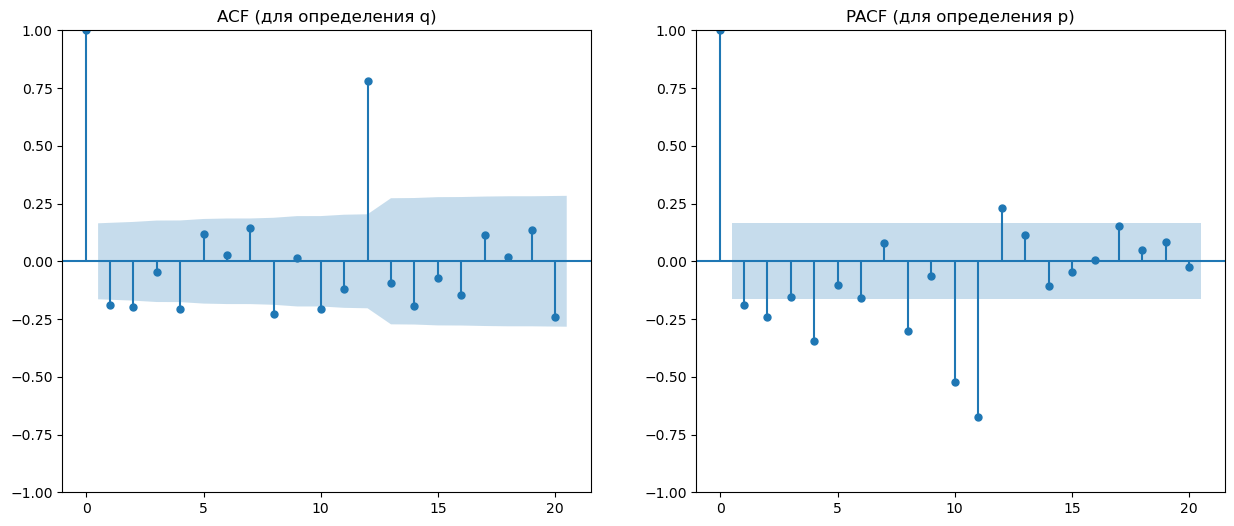

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
plot_acf(airlines_diff2, ax=ax1, lags=20)
ax1.set_title('ACF (для определения q)')
plot_pacf(airlines_diff2, ax=ax2, lags=20)
ax2.set_title('PACF (для определения p)')
plt.show()

In [12]:
p_range = range(0, 3)  
d_range = [2]             
q_range = range(0, 3)  

best_aic = float('inf')
best_order = None
best_model = None

for p, d, q in product(p_range, d_range, q_range):
    try:
        model = ARIMA(airlines_passengers['Count'], order=(p, d, q))
        results = model.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_order = (p, d, q)
            best_model = results
    except Exception as e:
        continue  

print(f"Оптимальные параметры ARIMA: {best_order}")
print(f"AIC: {best_aic:.2f}")

Оптимальные параметры ARIMA: (1, 2, 2)
AIC: 1391.91


In [13]:
model_arima = ARIMA(airlines_passengers['Count'], order=best_order)
results_arima = model_arima.fit()

In [14]:
forecast = results_arima.get_forecast(steps=12)
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

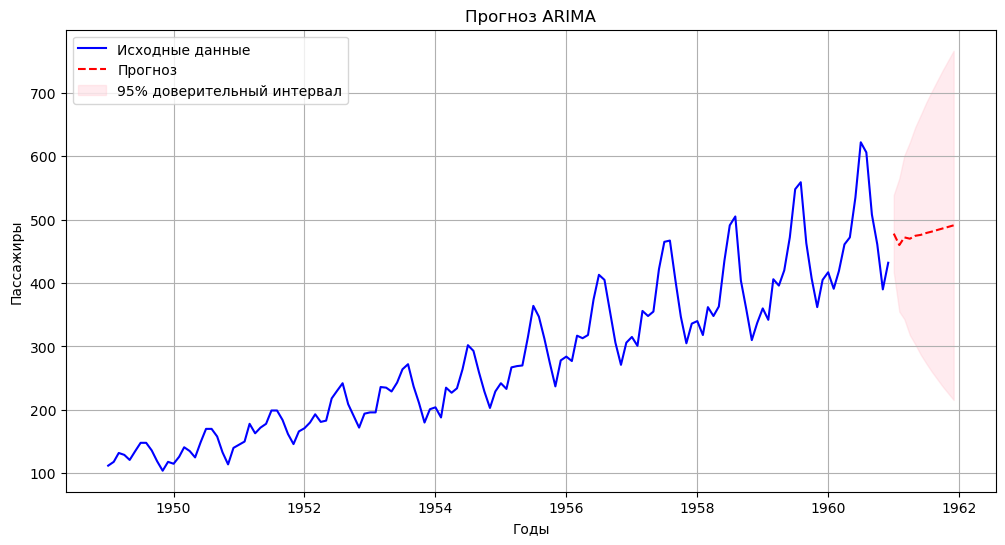

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(airlines_passengers['Count'], label='Исходные данные', color='blue')
plt.plot(forecast_mean, label='Прогноз', color='red', linestyle='--')
plt.fill_between(
    forecast_conf_int.index,
    forecast_conf_int.iloc[:, 0],
    forecast_conf_int.iloc[:, 1],
    color='pink', alpha=0.3, label='95% доверительный интервал'
)
plt.title('Прогноз ARIMA')
plt.xlabel('Годы')
plt.ylabel('Пассажиры')
plt.legend()
plt.grid(True)
plt.show()

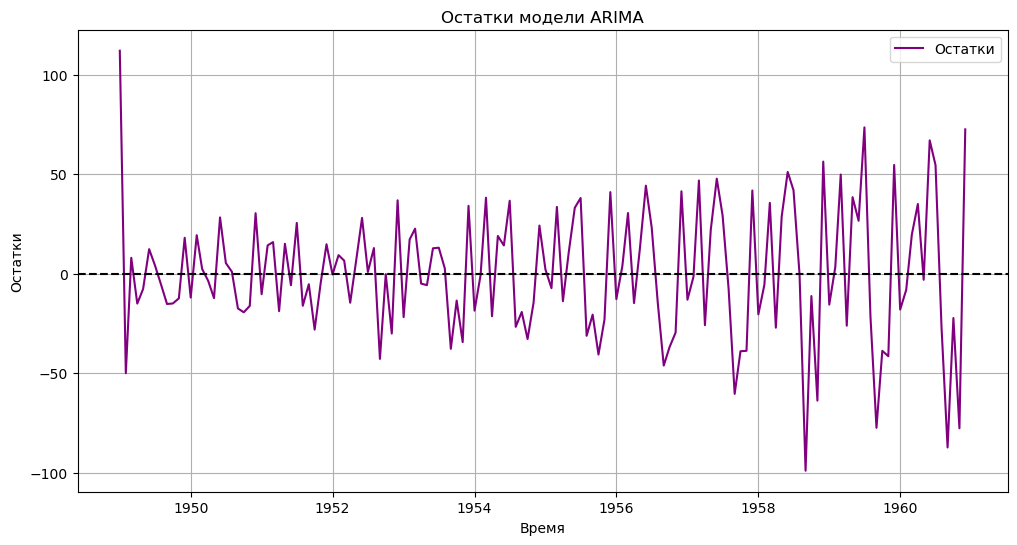

In [16]:
residuals = results_arima.resid

plt.figure(figsize=(12, 6))
plt.plot(residuals, label='Остатки', color='purple')
plt.axhline(0, color='black', linestyle='--')
plt.title('Остатки модели ARIMA')
plt.xlabel('Время')
plt.ylabel('Остатки')
plt.legend()
plt.grid(True)
plt.show()

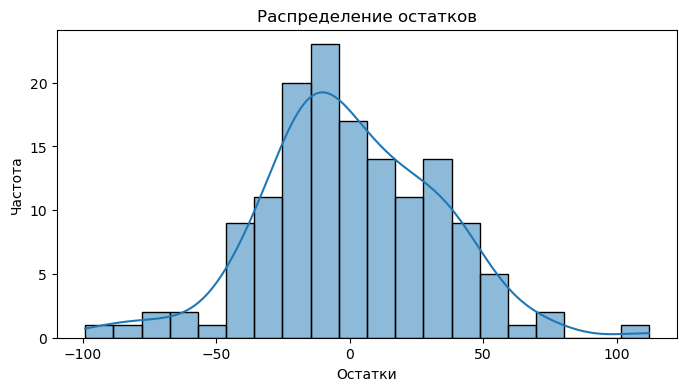

In [17]:
plt.figure(figsize=(8, 4))
sns.histplot(residuals, kde=True, bins=20)
plt.title('Распределение остатков')
plt.xlabel('Остатки')
plt.ylabel('Частота')
plt.show()

In [27]:
df = airlines_passengers[['Count']].copy()

In [28]:
for lag in range(1, 13):
    df[f'lag_{lag}'] = df['Count'].shift(lag)

In [29]:
df['target'] = df['Count'].shift(-1)

In [30]:
df.dropna(inplace=True)
print("\nДанные с лагами (первые 5 строк):")
print(df.head())


Данные с лагами (первые 5 строк):
            Count  lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  lag_7  lag_8  \
Month                                                                       
1950-01-01    115  118.0  104.0  119.0  136.0  148.0  148.0  135.0  121.0   
1950-02-01    126  115.0  118.0  104.0  119.0  136.0  148.0  148.0  135.0   
1950-03-01    141  126.0  115.0  118.0  104.0  119.0  136.0  148.0  148.0   
1950-04-01    135  141.0  126.0  115.0  118.0  104.0  119.0  136.0  148.0   
1950-05-01    125  135.0  141.0  126.0  115.0  118.0  104.0  119.0  136.0   

            lag_9  lag_10  lag_11  lag_12  target  
Month                                              
1950-01-01  129.0   132.0   118.0   112.0   126.0  
1950-02-01  121.0   129.0   132.0   118.0   141.0  
1950-03-01  135.0   121.0   129.0   132.0   135.0  
1950-04-01  148.0   135.0   121.0   129.0   125.0  
1950-05-01  148.0   148.0   135.0   121.0   149.0  


In [31]:
X = df.drop('target', axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

In [32]:
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
}

results_ml = {}

In [33]:
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    results_ml[name] = {'MAE': mae, 'RMSE': rmse}
    
    print(f"\n{name}:")
    print(f"  MAE:  {mae:.2f}")
    print(f"  RMSE: {rmse:.2f}")


Linear Regression:
  MAE:  14.02
  RMSE: 18.04

Random Forest:
  MAE:  32.51
  RMSE: 46.94


In [34]:
best_ml_model = min(results_ml.keys(), key=lambda x: results_ml[x]['RMSE'])
print(f"\nЛучшая ML‑модель: {best_ml_model}")


Лучшая ML‑модель: Linear Regression


In [35]:
best_model_obj = models[best_ml_model]
best_model_obj.fit(X_train, y_train)
y_pred_best = best_model_obj.predict(X_test)

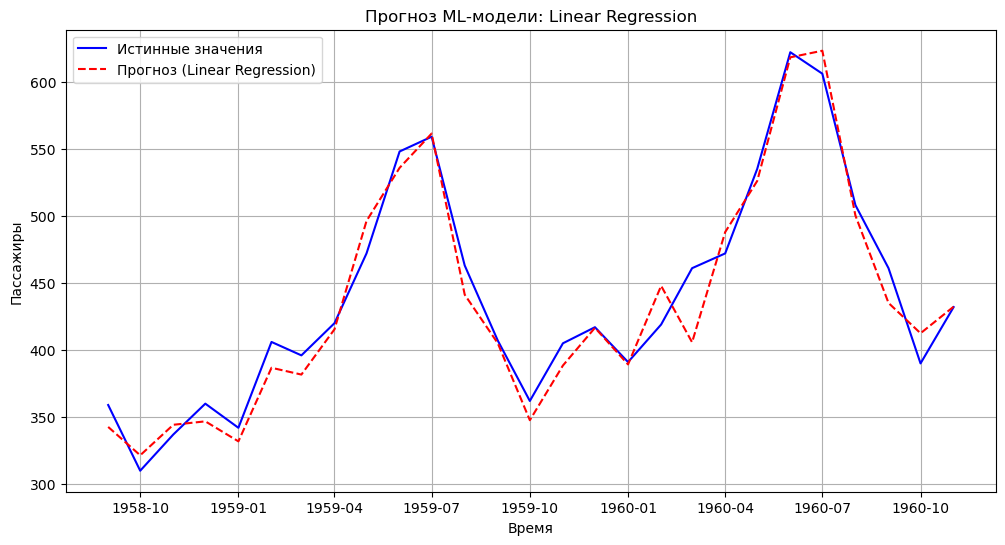

In [36]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Истинные значения', color='blue')
plt.plot(y_test.index, y_pred_best, label=f'Прогноз ({best_ml_model})', color='red', linestyle='--')
plt.title(f'Прогноз ML‑модели: {best_ml_model}')
plt.xlabel('Время')
plt.ylabel('Пассажиры')
plt.legend()
plt.grid(True)
plt.show()

In [37]:
print("\nСравнение метрик всех ML‑моделей:")
for name, metrics in results_ml.items():
    print(f"{name}: MAE={metrics['MAE']:.2f}, RMSE={metrics['RMSE']:.2f}")


Сравнение метрик всех ML‑моделей:
Linear Regression: MAE=14.02, RMSE=18.04
Random Forest: MAE=32.51, RMSE=46.94


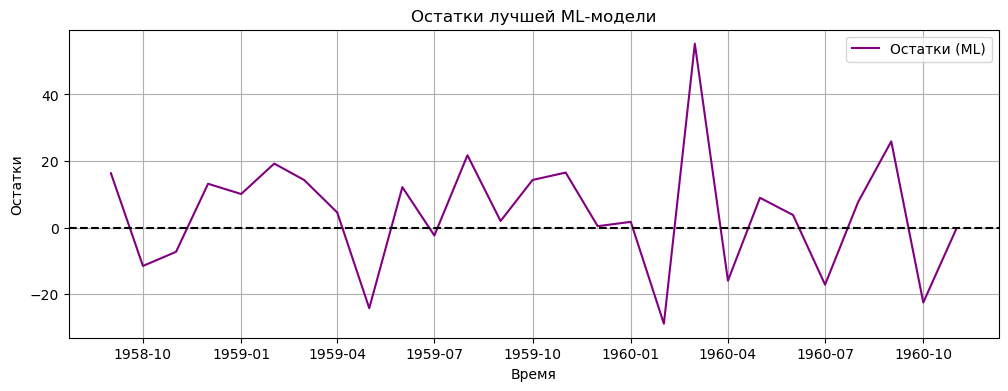

In [38]:
residuals_ml = y_test - y_pred_best
plt.figure(figsize=(12, 4))
plt.plot(residuals_ml, label='Остатки (ML)', color='purple')
plt.axhline(0, color='black', linestyle='--')
plt.title('Остатки лучшей ML‑модели')
plt.xlabel('Время')
plt.ylabel('Остатки')
plt.legend()
plt.grid(True)
plt.show()

In [39]:
if best_ml_model == 'Linear Regression':
    coefficients = pd.DataFrame(
        best_model_obj.coef_,
        X.columns,
        columns=['Коэффициент']
    )
    print("\nКоэффициенты линейной модели:")
    print(coefficients)


Коэффициенты линейной модели:
        Коэффициент
Count      0.862126
lag_1     -0.095680
lag_2      0.065485
lag_3     -0.080679
lag_4      0.140758
lag_5     -0.166087
lag_6      0.116003
lag_7     -0.112075
lag_8      0.074715
lag_9     -0.083448
lag_10     0.161258
lag_11     0.935249
lag_12    -0.820159
